In [33]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from sunpy.map import Map
from astropy.table import Table
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [2]:
class nlfff:
      
      def __init__(self,filename):
            self.filename=filename

            nc=netCDF4.Dataset(self.filename,'r')
            self.NOAA=nc.NOAA
            self.year_month_day_time=nc.year_month_day_time
            self.project=nc.project
            self.production_date=nc.production_date
            self.version=nc.version
            self.data_doi=nc.data_doi
            self.http_link=nc.http_link
            self.Distributor=nc.Distributor
            
            nc_x=nc.variables['x']
            self.x=nc_x[:]
            print(nc_x.long_name,' unit:',nc_x.units)
            nc_y=nc.variables['y']
            self.y=nc_y[:]
            print(nc_y.long_name,' unit:',nc_y.units)
            nc_z=nc.variables['z']
            self.z=nc_z[:]
            print(nc_z.long_name,' unit:',nc_z.units)
            
            nc_bx=nc.variables['Bx']
            self.bx=nc_bx[:].transpose(2,1,0)
            print(nc_bx.long_name,' unit:',nc_bx.units)
            nc_by=nc.variables['By']
            self.by=nc_by[:].transpose(2,1,0)
            print(nc_by.long_name,' unit:',nc_by.units)
            nc_bz=nc.variables['Bz']
            self.bz=nc_bz[:].transpose(2,1,0)
            print(nc_bz.long_name,' unit:',nc_bz.units)
            
            nc_bxp=nc.variables['Bx_pot']
            self.bx_pot=nc_bxp[:].transpose(2,1,0)
            print(nc_bxp.long_name,' unit:',nc_bxp.units)
            nc_byp=nc.variables['By_pot']
            self.by_pot=nc_byp[:].transpose(2,1,0)
            print(nc_byp.long_name,' unit:',nc_byp.units)
            nc_bzp=nc.variables['Bz_pot']
            self.bz_pot=nc_bzp[:].transpose(2,1,0)
            print(nc_bzp.long_name,' unit:',nc_bzp.units)
            
      def info(self):
            self.Lx_Mm=max(self.x) - min(self.x)
            self.Ly_Mm=max(self.y) - min(self.y)
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})\n')
            print(f"NOAA",self.NOAA)
            print(f'year_month_day_time',self.year_month_day_time)
            print(f"project",self.project)
            print(f"production_date",self.production_date)
            print(f"version",self.version)
            print(f"data_doi",self.data_doi)
            print(f"http_link",self.http_link)
            print(f"Distributor",self.Distributor)

      def plot(self):
            xs=12.0
            ys=4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))
            
            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.bx[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.by[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.bz[:,:,0].transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')

In [3]:
class sharp:

      def __init__(self, filename):
            self.filename = filename

            hmi_p = filename + ".Bp.fits"
            hmi_t = filename + ".Bt.fits"
            hmi_r = filename + ".Br.fits"
            err_p = filename + ".Bp_err.fits"
            err_t = filename + ".Bt_err.fits"
            err_r = filename + ".Br_err.fits"

            self.Bx = Map(hmi_p).data.transpose()
            self.By = -Map(hmi_t).data.transpose()
            self.Bz = Map(hmi_r).data.transpose()
            self.Bx_err = Map(err_p).data.transpose()
            self.By_err = -Map(err_t).data.transpose()
            self.Bz_err = Map(err_r).data.transpose()

            self.hmi_cube = np.stack([self.Bx, self.By, self.Bz], axis=-1)
            self.err_cube = np.stack([self.Bx_err, self.By_err, self.Bz_err], axis=-1)
            
            self.meta = Map(hmi_p).meta

            # 2 * pi * R_sun (Mm) = 360 (deg)
            Mm_per_deg = (2 * np.pi * 696)/360

            # cdelt1 = deg_per_pixel in x
            # cdelt2 = deg_per_pixel in y
            # Mm_per_pixel = Mm_per_deg * deg_per_pixel
            self.dx_Mm_per_pixel = Mm_per_deg * self.meta['cdelt1']
            self.dy_Mm_per_pixel = Mm_per_deg * self.meta['cdelt2']

            self.Lx_pixel, self.Ly_pixel = self.Bx.shape
            
            self.Lx_Mm, self.Ly_Mm = self.Lx_pixel * self.dx_Mm_per_pixel, self.Ly_pixel * self.dy_Mm_per_pixel
            

            self.x = np.linspace(-self.Lx_Mm/2, self.Lx_Mm/2, self.Lx_pixel+1)
            self.y = np.linspace(-self.Ly_Mm/2, self.Ly_Mm/2, self.Ly_pixel+1)
            
      def info(self):
            print(f'(Lx, Ly) in pixel = {(self.Lx_pixel, self.Ly_pixel)}')
            print(f'(Lx, Ly) in Mm = ({self.Lx_Mm:.2f}, {self.Ly_Mm:.2f})')
            return self.meta

      def plot(self):
            xs = 12.0
            ys = 4.0

            xmin=min(self.x)
            xmax=max(self.x)
            ymin=min(self.y)
            ymax=max(self.y)

            plt.close()
            fig=plt.figure(figsize=(xs,ys))
            ax1=fig.add_axes((0.08,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax2=fig.add_axes((0.4,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            ax3=fig.add_axes((0.72,0.35,0.25,0.25*xs/ys*(ymax-ymin)/(xmax-xmin)))
            cax1=fig.add_axes((0.08,0.15,0.25,0.05))
            cax2=fig.add_axes((0.4,0.15,0.25,0.05))
            cax3=fig.add_axes((0.72,0.15,0.25,0.05))

            vmin=-3000.0 
            vmax=3000.0
            
            im1=ax1.pcolormesh(self.x,self.y,self.Bx.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im2=ax2.pcolormesh(self.x,self.y,self.By.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')
            im3=ax3.pcolormesh(self.x,self.y,self.Bz.transpose(),vmin=vmin,vmax=vmax,cmap='gist_gray',shading='auto')

            cbar1=plt.colorbar(im1,cax=cax1,orientation='horizontal')
            cbar2=plt.colorbar(im2,cax=cax2,orientation='horizontal')
            cbar3=plt.colorbar(im3,cax=cax3,orientation='horizontal')
            
            ax1.set_title('Bx [G]')
            ax1.set_xlabel('x [Mm]')
            ax1.set_ylabel('y [Mm]')
            
            ax2.set_title('By [G]')
            ax2.set_xlabel('x [Mm]')
            ax2.set_ylabel('y [Mm]')
            
            ax3.set_title('Bz [G]')
            ax3.set_xlabel('x [Mm]')
            ax3.set_ylabel('y [Mm]')

x (westward)  unit: Mm
y (northward)  unit: Mm
z (out ot photosphere)  unit: Mm
Bx (westward)  unit: G
By (northward)  unit: G
Bz (out of photosphere)  unit: G
Bx_pot (westward)  unit: G
By_pot (northward)  unit: G
Bz_pot (out of photosphere)  unit: G


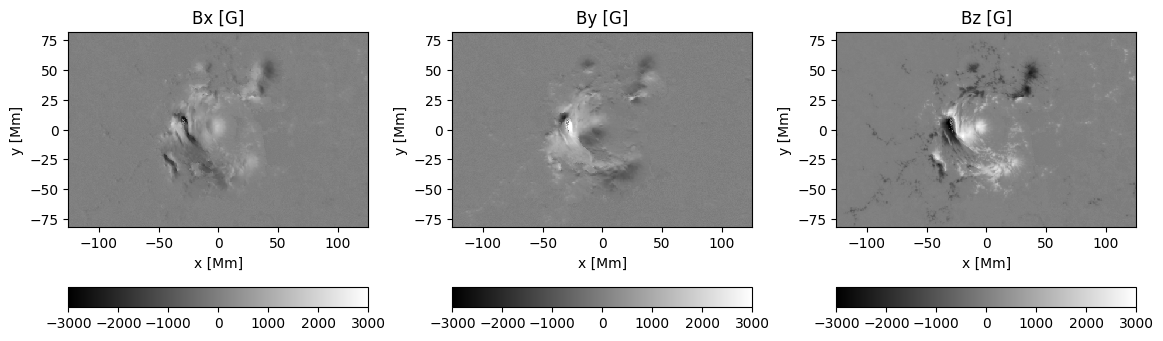

In [4]:
data = nlfff('/nas/obsdata/isee_nlfff_v1.2/12673/12673_20170905_202400.nc')
data.plot()

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html forthe FITS unit standards. [sunpy.map.mapbase]


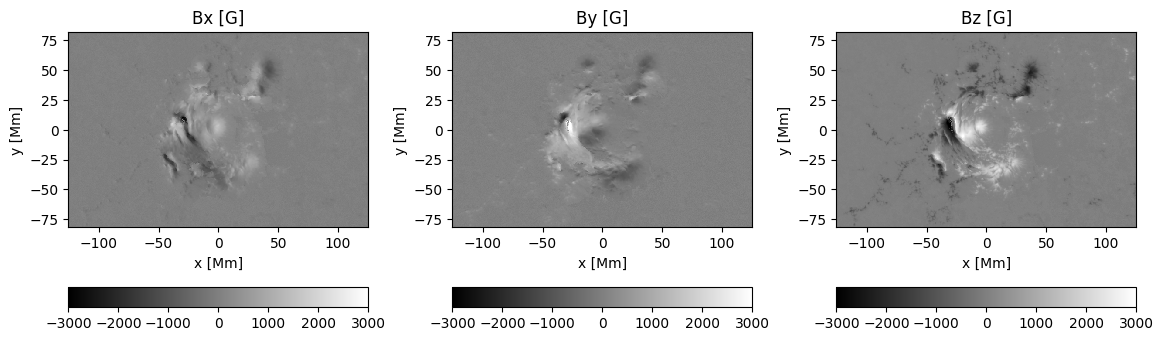

In [5]:
obsdata = sharp('/nas/obsdata/sdo/hmi/SHARP_CEA_720S_AR/NOAA12673/hmi.sharp_cea_720s.7115.20170905_202400_TAI')
obsdata.plot()

In [19]:
b_n = np.array(data.bz[:, :, 0])
height = data.bz.shape[2]
batch_size = 1000

In [20]:
cube_shape = (*b_n.shape, height)
cube_shape

(513, 257, 257)

In [26]:
b_n = b_n.reshape((-1,)).astype(np.float32)
b_n

array([ 28.25,  46.63, -39.22, ...,  13.29, -30.01,   0.  ], dtype=float32)

In [27]:
coords = np.stack(np.mgrid[:cube_shape[0]:1, :cube_shape[1]:1, :cube_shape[2]:1], -1).reshape((-1, 3))
coords

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [512, 256, 254],
       [512, 256, 255],
       [512, 256, 256]])

In [28]:
r_p = np.stack(np.mgrid[:cube_shape[0], :cube_shape[1], :1], -1).reshape((-1, 3))
r_p

array([[  0,   0,   0],
       [  0,   1,   0],
       [  0,   2,   0],
       ...,
       [512, 254,   0],
       [512, 255,   0],
       [512, 256,   0]])

In [31]:
class PotentialModel(nn.Module):

    def __init__(self, b_n, r_p):
        super().__init__()
        self.register_buffer('b_n', b_n)
        self.register_buffer('r_p', r_p)
        c = np.zeros((1, 3))
        c[:, 2] = (1 / np.sqrt(2 * np.pi))
        c = torch.tensor(c, dtype=torch.float32, )
        self.register_buffer('c', c)

    def forward(self, coord):
        v1 = self.b_n[:, None]
        v2 = 2 * np.pi * ((-self.r_p[:, None] + coord[None, :] + self.c[None]) ** 2).sum(-1) ** 0.5
        potential = torch.sum(v1 / v2, dim=0)
        return potential

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
with torch.no_grad():
    b_n = torch.tensor(b_n, dtype=torch.float32, )
    r_p = torch.tensor(r_p, dtype=torch.float32, )
    model = nn.DataParallel(PotentialModel(b_n, r_p)).to(device)

    coords = torch.tensor(coords, dtype=torch.float32)
    potential = []
    loader = DataLoader(TensorDataset(coords), batch_size=batch_size, num_workers=8)
    it = tqdm(loader, desc='Potential Field')
    for coord, in it:
        coord = coord.to(device)
        p_batch = model(coord)
        potential += [p_batch]

Potential Field: 100%|██████████| 33884/33884 [05:15<00:00, 107.46it/s]


In [44]:
potential = torch.cat(potential).view(cube_shape).cpu().numpy()

In [46]:
b_potential = - 1 * np.stack(np.gradient(potential, axis=[0, 1, 2], edge_order=2), axis=-1)

In [50]:
data_pot = np.stack([np.array(data.bx_pot), np.array(data.by_pot), np.array(data.bz_pot)], axis=-1)

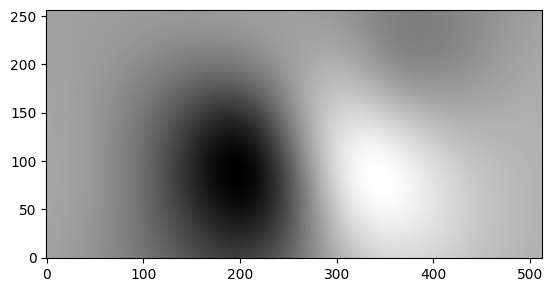

In [62]:
plt.imshow(b_potential[:, :, 100, 0].transpose(), origin='lower', cmap='gray')

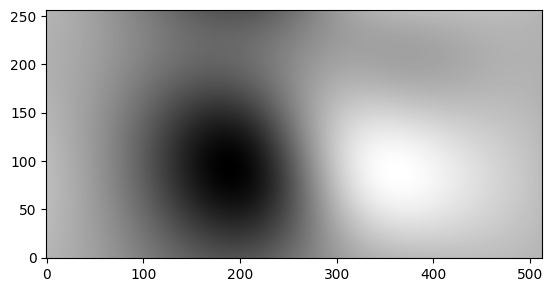

In [61]:
plt.imshow(data_pot[:, :, 100, 0].transpose(), origin='lower', cmap='gray')

In [63]:
class Sine(nn.Module):
    def __init__(self, w0=1.):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class BModel(nn.Module):

    def __init__(self, in_coords, out_values, dim, pos_encoding=False):
        super().__init__()
        self.d_in = nn.Linear(in_coords, dim)
        lin = [nn.Linear(dim, dim) for _ in range(8)]
        self.linear_layers = nn.ModuleList(lin)
        self.d_out = nn.Linear(dim, out_values)
        self.activation = Sine()  # torch.tanh

    def forward(self, x):
        x = self.activation(self.d_in(x))
        for l in self.linear_layers:
            x = self.activation(l(x))
        x = self.d_out(x)
        return x

In [64]:
model = BModel(3, 3, dim=256, pos_encoding=False)

In [66]:
parallel_model = nn.DataParallel(model).to(device)
opt = torch.optim.Adam(parallel_model.parameters(), lr=5e-4)

In [ ]:
start_iteration = 0
lambda_B = 1000
history = {'iteration': [], 'height': [],
            'b_loss': [], 'divergence_loss': [], 'force_loss': [], 'sigma_angle': []}